In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import glob
import tensorflow_hub as hub
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# ========= Step 1: Data Preprocessing ==========

IMG_SIZE = 224  # Image input size for ViT

def preprocess_image(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_images_and_labels(dataset_dir):
    images = []
    labels = []

    for label_name in ['benign', 'malignant']:
        class_dir = os.path.join(dataset_dir, label_name)
        image_files = glob.glob(os.path.join(class_dir, '*.png'))
        print(image_files)
        print(f"Found {len(image_files)} images in {class_dir}")
        image_files = [f for f in image_files if "_mask" not in os.path.basename(f)]
        print(f"After filtering, {len(image_files)} images remain in {class_dir}")
        print(image_files)

        for file in image_files:
            img = cv2.imread(file)
            img = cv2.GaussianBlur(img, (5,5), 1.0)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l_eq = clahe.apply(l)
            lab_eq = cv2.merge((l_eq, a, b))
            img_eq_bgr = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

            # Convert to RGB (common for ML code)
            img = cv2.cvtColor(img_eq_bgr, cv2.COLOR_BGR2RGB)
            img = (img .astype(np.float32) / 255.0)
            images.append(img)
            labels.append(label_name)  # Use string labels

    return np.array(images), np.array(labels, dtype=str)

In [49]:
# Load the dataset
dataset_dir = '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT'
X, y = load_images_and_labels(dataset_dir)

['/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (1).png', '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (1)_mask.png', '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (10).png', '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (10)_mask.png', '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (100).png', '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', '/content/drive/MyDrive/My Knowledge Base/My Projects/Dataset/Medical Image classification/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', '/content/drive/M

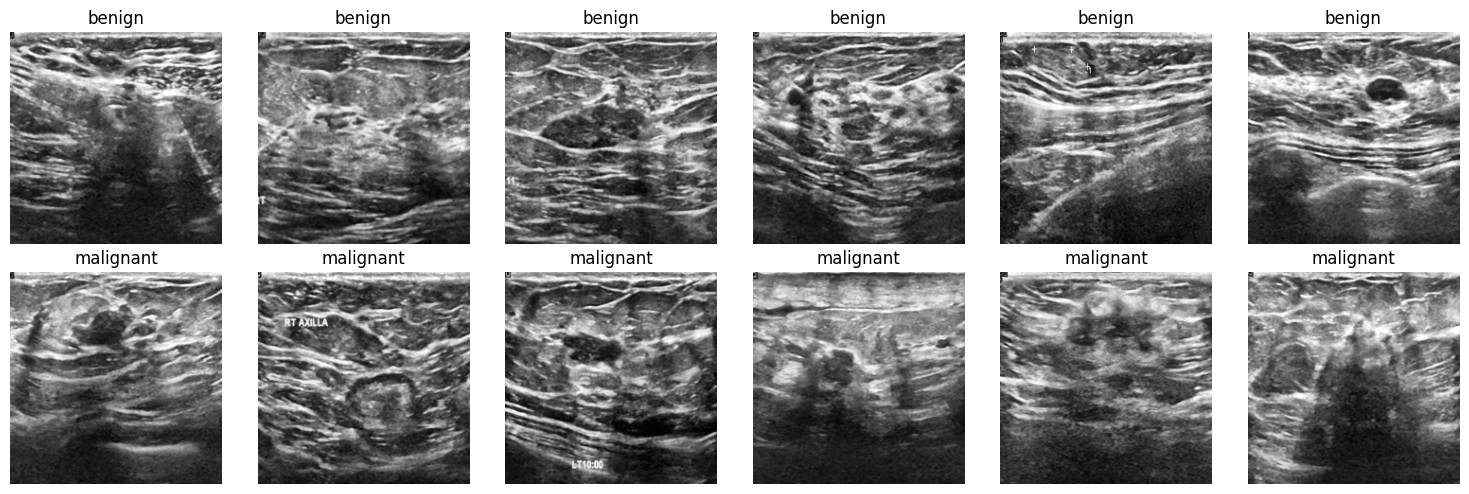

In [50]:
# Function to display sample images
def display_samples(images, labels, class_names, num_samples=6):
    plt.figure(figsize=(15, 5))
    for i, class_name in enumerate(class_names):
        # Get indices of images belonging to the current class
        class_indices = np.where(labels == class_name)[0]

        # Select a random subset of images from this class
        if len(class_indices) > num_samples:
            sample_indices = np.random.choice(class_indices, num_samples, replace=False)
        else:
            sample_indices = class_indices

        # Display the sample images
        for j, idx in enumerate(sample_indices):
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx])
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 6 samples of each class from the training data
display_samples(X, y, ["benign", "malignant"], num_samples=6)

In [51]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Create tf.data.Datasets
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [52]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (485, 224, 224, 3)
y_train shape:  (485,)
X_test shape:  (162, 224, 224, 3)
y_test shape:  (162,)


In [53]:
# ========= Step 2: Feature Extraction Using ViT ==========

vit_fe = hub.load("https://tfhub.dev/sayakpaul/vit_b16_fe/1")  # ViT feature extractor

In [54]:
def extract_cls_features(images):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return vit_fe(images)

# Extract CLS features
cls_train = extract_cls_features(X_train)
cls_test = extract_cls_features(X_test)

# Separate CLS features by class label
cls_class0 = cls_train[y_train == 'benign']
cls_class1 = cls_train[y_train == 'malignant']

print("Benign CLS shape:", cls_class0.shape)
print("Malignant CLS shape:", cls_class1.shape)

Benign CLS shape: (328, 768)
Malignant CLS shape: (157, 768)


In [55]:
'''# ========= Step 3: Dimensionality Reduction with LDA ==========
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers for LDA
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Apply LDA to the training features
n_components_lda = 1  # LDA can extract at most C-1 components, where C is the number of classes (2 classes -> max 1 component)
lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
cls_train_lda = lda.fit_transform(cls_train, y_train_encoded)

# Apply the same LDA transformation to the test features
cls_test_lda = lda.transform(cls_test)

print(f"Original training features shape: {cls_train.shape}")
print(f"Reduced training features shape after LDA: {cls_train_lda.shape}")
print(f"Original test features shape: {cls_test.shape}")
print(f"Reduced test features shape after LDA: {cls_test_lda.shape}")

# Since LDA with 2 classes results in 1 component, we'll reshape for consistency with previous steps if needed
# Otherwise, we'll proceed with the 1D array

# Separate LDA-reduced features by class label
cls_class0_lda = cls_train_lda[y_train == 'benign']
cls_class1_lda = cls_train_lda[y_train == 'malignant']

cls_class0_new = tf.convert_to_tensor(cls_class0_lda)
cls_class1_new = tf.convert_to_tensor(cls_class1_lda)

cls_test_new = tf.convert_to_tensor(cls_test_lda)'''

'# ========= Step 3: Dimensionality Reduction with LDA ==========\nfrom sklearn.discriminant_analysis import LinearDiscriminantAnalysis\nfrom sklearn.preprocessing import LabelEncoder\n\n# Encode string labels to integers for LDA\nlabel_encoder = LabelEncoder()\ny_train_encoded = label_encoder.fit_transform(y_train)\ny_test_encoded = label_encoder.transform(y_test)\n\n\n# Apply LDA to the training features\nn_components_lda = 1  # LDA can extract at most C-1 components, where C is the number of classes (2 classes -> max 1 component)\nlda = LinearDiscriminantAnalysis(n_components=n_components_lda)\ncls_train_lda = lda.fit_transform(cls_train, y_train_encoded)\n\n# Apply the same LDA transformation to the test features\ncls_test_lda = lda.transform(cls_test)\n\nprint(f"Original training features shape: {cls_train.shape}")\nprint(f"Reduced training features shape after LDA: {cls_train_lda.shape}")\nprint(f"Original test features shape: {cls_test.shape}")\nprint(f"Reduced test features sha

In [56]:
# ========= Step 3: Dimensionality Reduction with PCA ==========
from sklearn.decomposition import PCA

# Apply PCA to the training features
n_components = 20
pca = PCA(n_components=n_components, random_state=42)
cls_train_pca = pca.fit_transform(cls_train)

# Apply the same PCA transformation to the test features
cls_test_pca = pca.transform(cls_test)

print(f"Original training features shape: {cls_train.shape}")
print(f"Reduced training features shape after PCA: {cls_train_pca.shape}")
print(f"Original test features shape: {cls_test.shape}")
print(f"Reduced test features shape after PCA: {cls_test_pca.shape}")

# Separate PCA-reduced features by class label
cls_class0_pca = cls_train_pca[y_train == 'benign']
cls_class1_pca = cls_train_pca[y_train == 'malignant']

cls_class0_new = tf.convert_to_tensor(cls_class0_pca)
cls_class1_new = tf.convert_to_tensor(cls_class1_pca)

cls_test_new = tf.convert_to_tensor(cls_test_pca)

Original training features shape: (485, 768)
Reduced training features shape after PCA: (485, 20)
Original test features shape: (162, 768)
Reduced test features shape after PCA: (162, 20)


In [57]:
'''cls_class0_new = cls_class0
cls_class1_new = cls_class1

cls_test_new = cls_test'''

'cls_class0_new = cls_class0\ncls_class1_new = cls_class1\n\ncls_test_new = cls_test'

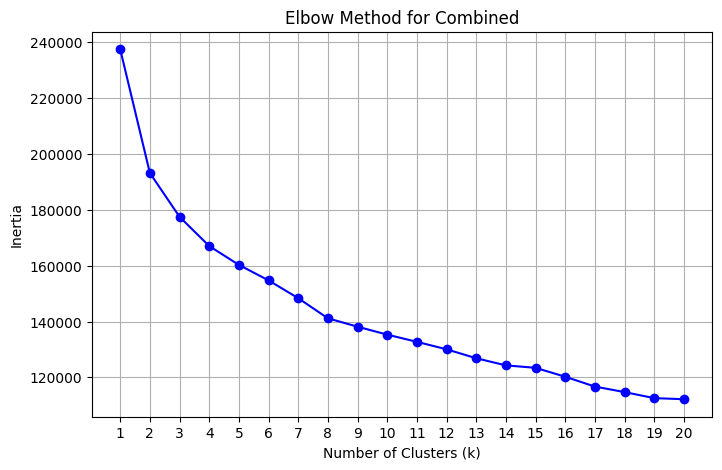

In [58]:
# Finding Optimal 'K' By Elbow Method

def plot_elbow_method(cls_embeddings, max_k=15, class_name='Class'):
    inertias = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(cls_embeddings)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method for {class_name}')
    plt.xticks(K_range)
    plt.grid(True)
    plt.show()


# Combine benign and malignant CLS embeddings
cls_combined = tf.concat([cls_class0_new, cls_class1_new], axis=0)

# Plot elbow method for combined classes
plot_elbow_method(cls_combined.numpy(), max_k=20, class_name='Combined')

In [65]:
# Assigning Cluster Labels to Training Images

from sklearn.cluster import KMeans

k = 8

# Apply KMeans to benign class
kmeans_benign = KMeans(n_clusters=k, n_init='auto', random_state=42)
kmeans_benign.fit(cls_class0_new.numpy())
labels_benign = kmeans_benign.labels_

# Apply KMeans to malignant class
kmeans_malignant = KMeans(n_clusters=k, n_init='auto', random_state=42)
kmeans_malignant.fit(cls_class1_new.numpy())
labels_malignant = kmeans_malignant.labels_

print("Benign KMeans Cluster Labels:")
print(labels_benign)

print("\nMalignant KMeans Cluster Labels:")
print(labels_malignant)

Benign KMeans Cluster Labels:
[0 5 6 6 5 3 5 0 0 4 3 6 7 6 3 2 7 2 0 1 6 7 0 6 6 3 6 5 0 7 4 6 0 6 5 1 5
 2 3 0 1 0 4 4 7 2 5 2 7 3 5 2 7 2 2 3 2 0 3 7 1 5 6 0 6 0 4 0 0 5 1 0 0 4
 5 2 4 5 2 6 2 0 0 2 7 1 6 1 4 6 7 3 6 1 6 1 5 2 7 2 1 0 6 0 4 0 0 3 7 4 6
 0 5 0 1 2 1 0 6 2 6 4 0 4 0 6 5 2 0 1 6 2 3 5 2 2 3 0 1 2 0 6 0 2 6 6 0 0
 3 3 6 1 5 7 0 3 2 6 1 7 6 1 2 6 6 7 7 1 4 6 5 0 5 0 7 6 0 2 2 5 2 2 6 6 7
 7 3 0 3 4 2 3 4 6 7 5 7 6 5 0 0 3 2 2 6 2 7 6 1 6 7 6 4 0 5 0 6 4 7 7 7 6
 6 7 7 6 5 6 7 4 2 6 6 0 5 6 2 6 3 0 7 1 7 4 3 5 6 6 2 3 4 3 5 2 0 5 6 7 4
 3 3 5 7 0 6 5 4 5 5 0 3 3 5 7 0 6 0 0 6 6 0 1 5 1 5 3 0 2 6 1 0 0 3 3 6 5
 0 0 2 7 4 7 0 0 5 1 1 4 6 4 6 3 0 1 2 7 3 1 0 4 2 0 6 2 7 7 1 7]

Malignant KMeans Cluster Labels:
[7 6 7 2 6 7 3 6 0 3 6 7 6 7 7 4 4 6 0 3 7 6 0 2 6 7 4 0 6 6 7 2 4 0 5 5 3
 0 3 7 4 3 6 1 0 6 7 6 6 3 1 4 4 0 5 0 0 4 0 5 3 3 5 0 2 3 6 1 0 4 3 0 4 4
 6 7 1 2 0 6 4 2 0 7 7 3 7 2 4 7 5 4 4 1 5 6 4 3 3 5 4 2 5 1 1 2 3 1 1 4 0
 3 3 5 0 6 6 4 6 0 6 4 4 6 3 6 4 5 5 6 6 3 0 

In [66]:
# Finding Maximum Distance(radius) For Each Cluster

def compute_max_distances(cls_embeddings, labels, centroids):
    max_distances = []

    for i in range(k):
        # Select embeddings that belong to cluster i
        cluster_points = cls_embeddings[labels == i]
        # Compute Euclidean distances to the i-th centroid
        distances = tf.norm(cluster_points - centroids[i], axis=1)
        # Get the max distance
        max_dist = tf.reduce_max(distances)
        max_distances.append(max_dist.numpy())

    return max_distances

# Benign max distances (radii)
radii_benign_kmeans = compute_max_distances(cls_class0_new, labels_benign, tf.convert_to_tensor(kmeans_benign.cluster_centers_))

# Malignant max distances (radii)
radii_malignant_kmeans = compute_max_distances(cls_class1_new, labels_malignant, tf.convert_to_tensor(kmeans_malignant.cluster_centers_))

# Convert float32 values to plain Python floats
radii_benign = [float(r) for r in radii_benign_kmeans]
radii_malignant = [float(r) for r in radii_malignant_kmeans]

print("Max distances per benign cluster (radii):", radii_benign)
print("Max distances per malignant cluster (radii):", radii_malignant)

Max distances per benign cluster (radii): [25.577580051218202, 22.61442183005601, 25.65808724879851, 26.80249945269467, 23.09082574003227, 23.79988753230996, 22.76548463840228, 24.264404824884167]
Max distances per malignant cluster (radii): [22.1694041892942, 20.029100312150895, 18.002148581834586, 25.714101656870483, 21.271514342451905, 15.901690068463086, 19.71150233659946, 24.966104772252386]


In [67]:
# Classifying The Test Images Based On Majority Voting

def classify_with_majority_voting(
    test_embeddings,
    centroids_benign,
    centroids_malignant,
    radii_benign,
    radii_malignant,
    k
):
    predictions = []

    for emb in test_embeddings:
        benign_hits = 0
        malignant_hits = 0

        # Check against benign clusters
        for i in range(k):
            dist = tf.norm(emb - centroids_benign[i])
            if dist.numpy() <= radii_benign[i]:
                benign_hits += 1

        # Check against malignant clusters
        for i in range(k):
            dist = tf.norm(emb - centroids_malignant[i])
            if dist.numpy() <= radii_malignant[i]:
                malignant_hits += 1

        # Majority vote decision
        if benign_hits > malignant_hits:
            predictions.append("benign")
        elif malignant_hits > benign_hits:
            predictions.append("malignant")
        else:
            # Tie-breaker: find nearest cluster center among all 6
            all_centroids = tf.concat([centroids_benign, centroids_malignant], axis=0)
            dists = tf.norm(all_centroids - emb, axis=1)
            closest_idx = tf.argmin(dists).numpy()
            predicted_class = "benign" if closest_idx < 3 else "malignant"
            predictions.append(predicted_class)

    return predictions

Accuracy (majority voting): 0.7283950617283951


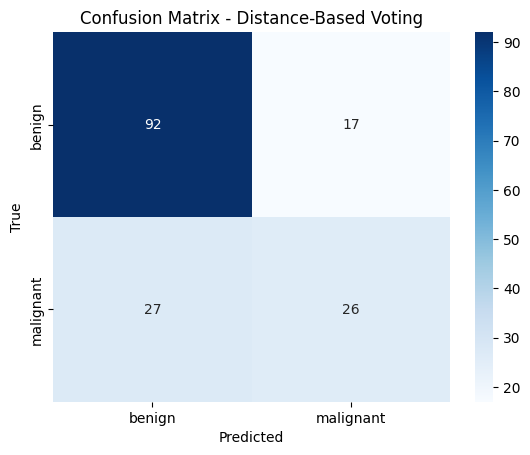

In [68]:
# Run the classifier
y_pred_majority = classify_with_majority_voting(
    cls_test_new,
    tf.convert_to_tensor(kmeans_benign.cluster_centers_),
    tf.convert_to_tensor(kmeans_malignant.cluster_centers_),
    radii_benign, radii_malignant, k
)

# Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy (majority voting):", accuracy_score(y_test, y_pred_majority))

cm = confusion_matrix(y_test, y_pred_majority, labels=["benign", "malignant"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Distance-Based Voting")
plt.show()

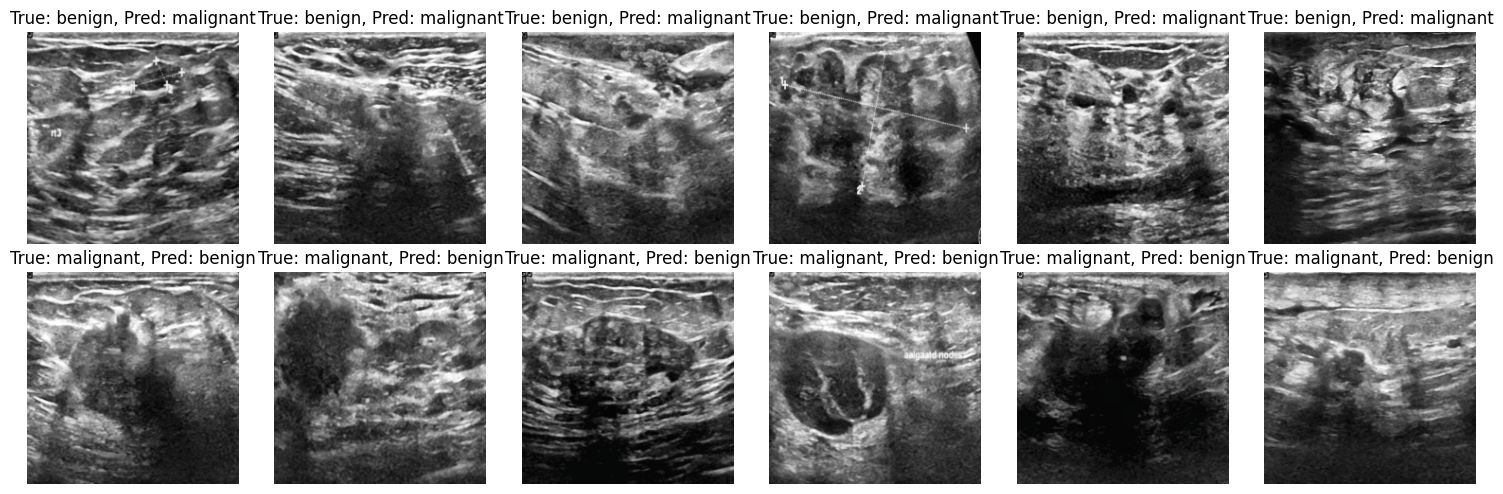

In [69]:
# Function to display sample images
def display_misclassified_samples(images, true_labels, pred_labels, class_names, num_samples=6):
    plt.figure(figsize=(15, 5))
    misclassified_indices = np.where(true_labels != pred_labels)[0]

    for i, class_name in enumerate(class_names):
        # Get indices of misclassified images belonging to the current class
        class_misclassified_indices = [idx for idx in misclassified_indices if true_labels[idx] == class_name]

        # Select a random subset of misclassified images from this class
        if len(class_misclassified_indices) > num_samples:
            sample_indices = np.random.choice(class_misclassified_indices, num_samples, replace=False)
        else:
            sample_indices = class_misclassified_indices

        # Display the sample images
        for j, idx in enumerate(sample_indices):
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx])
            plt.title(f"True: {true_labels[idx]}, Pred: {pred_labels[idx]}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 6 misclassified samples of each class from the test data
display_misclassified_samples(X_test, y_test, np.array(y_pred_majority), ["benign", "malignant"], num_samples=6)

Benign cluster distribution: {0: 61, 5: 37, 6: 62, 3: 32, 4: 26, 7: 40, 2: 42, 1: 28}
Malignant cluster distribution: {7: 20, 6: 28, 2: 10, 3: 24, 0: 24, 4: 23, 5: 13, 1: 15}


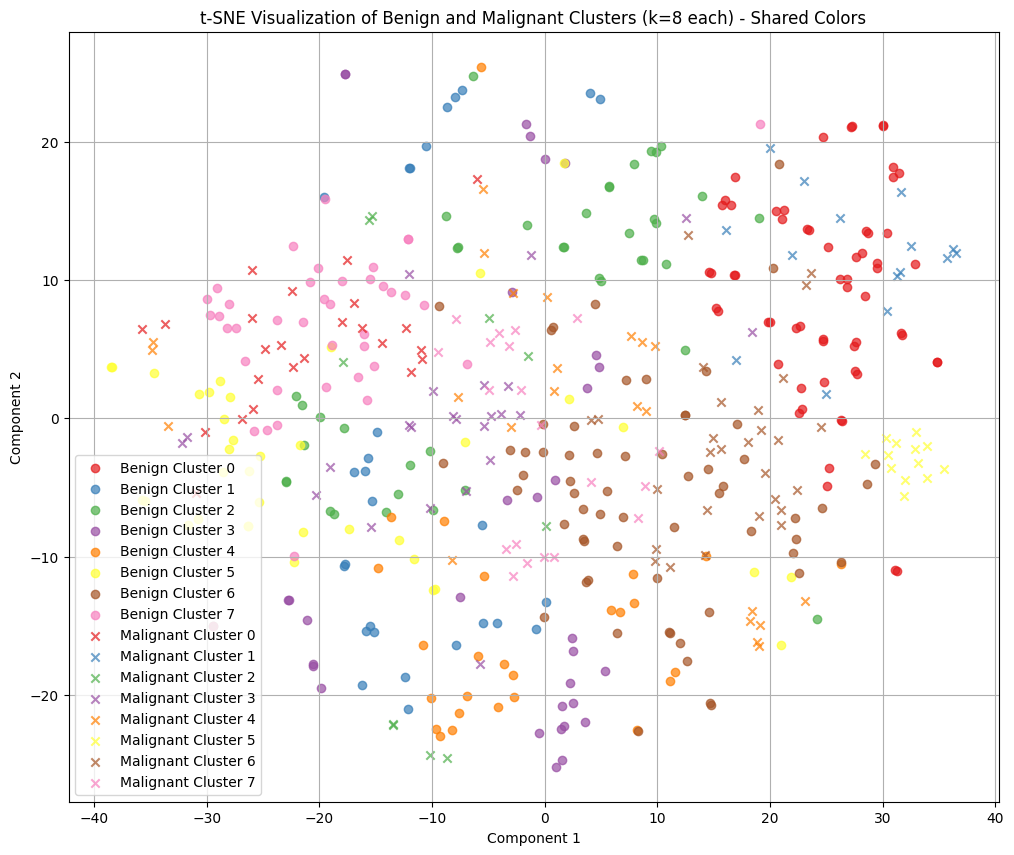

In [70]:
import seaborn as sns
from collections import Counter
from sklearn.manifold import TSNE

# Print cluster counts
benign_dist = {int(k): v for k, v in Counter(labels_benign).items()}
malignant_dist = {int(k): v for k, v in Counter(labels_malignant).items()}

print("Benign cluster distribution:", benign_dist)
print("Malignant cluster distribution:", malignant_dist)

# Combine data for t-SNE
cls_combined = tf.concat([cls_class0, cls_class1], axis=0).numpy()
labels_combined = np.concatenate([labels_benign, labels_malignant])
class_flags = np.array(['benign'] * len(labels_benign) + ['malignant'] * len(labels_malignant))  # for marker

# t-SNE to reduce to 2D
cls_2d = TSNE(n_components=2, random_state=42).fit_transform(cls_combined)

# Number of clusters (k) from your model
k = len(np.unique(labels_benign))  # or `k = len(np.unique(labels_malignant))`

# Define a color palette with k colors
palette = sns.color_palette("Set1", k)  # k colors

plt.figure(figsize=(12, 10))

# Plot benign with dots, using cluster color
for cluster_id in range(k):
    idx = (class_flags == 'benign') & (labels_combined == cluster_id)
    plt.scatter(cls_2d[idx, 0], cls_2d[idx, 1],
                label=f'Benign Cluster {cluster_id}',
                alpha=0.7, marker='o', color=palette[cluster_id])

# Plot malignant with crosses, using the same cluster color
for cluster_id in range(k):
    idx = (class_flags == 'malignant') & (labels_combined == cluster_id)
    plt.scatter(cls_2d[idx, 0], cls_2d[idx, 1],
                label=f'Malignant Cluster {cluster_id}',
                alpha=0.7, marker='x', color=palette[cluster_id])

plt.title(f"t-SNE Visualization of Benign and Malignant Clusters (k={k} each) - Shared Colors")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()